<a href="https://colab.research.google.com/github/Saheiyanda/Harmoye-Project/blob/main/forecasting_ozone_levels_in_madrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib  inline

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import glob
import missingno as msno
from fbprophet import Prophet

from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


['csvs_per_year', 'stations.csv', 'madrid.h5']


In [ ]:
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

# Read in data

In [ ]:
path =r'../input/csvs_per_year/csvs_per_year/' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

cols = ['date', 'station', 'BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY',
       'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']
frame = frame[cols]
frame = frame.sort_values(['station', 'date'])

frame.tail(3)

,date,station,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL
85821,2010-12-31 22:00:00,28079099,2.07,NaN,0.70,1.30,NaN,0.26,NaN,77.139999,155.899994,NaN,4.98,24.450001,16.25,NaN,12.99,1.56,4.11
85846,2010-12-31 23:00:00,28079099,1.49,NaN,0.62,1.14,NaN,0.26,NaN,68.290001,128.000000,NaN,5.24,22.240000,14.09,NaN,12.86,1.63,3.32
85871,2011-01-01 00:00:00,28079099,1.11,NaN,0.48,0.86,NaN,0.23,NaN,53.529999,82.430000,NaN,6.85,19.450001,14.54,NaN,11.71,1.66,2.46


# Missing data?

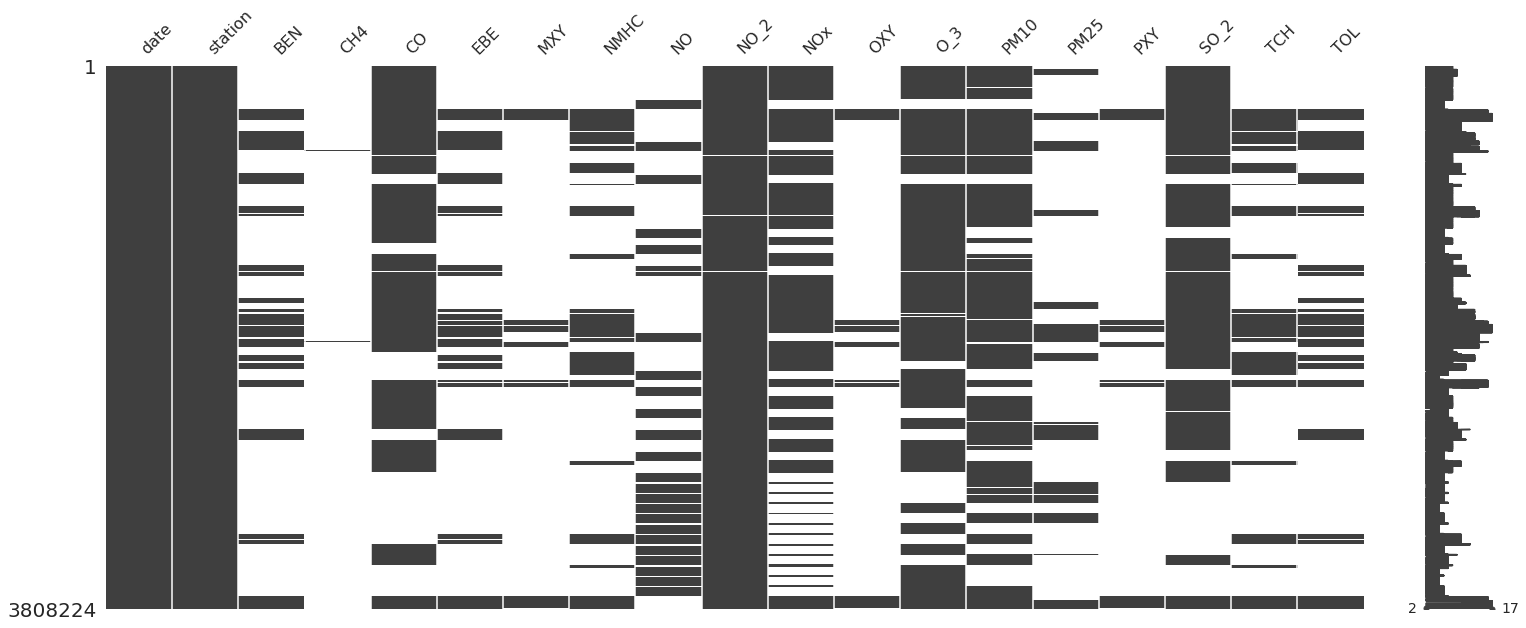

In [ ]:
msno.matrix(frame);

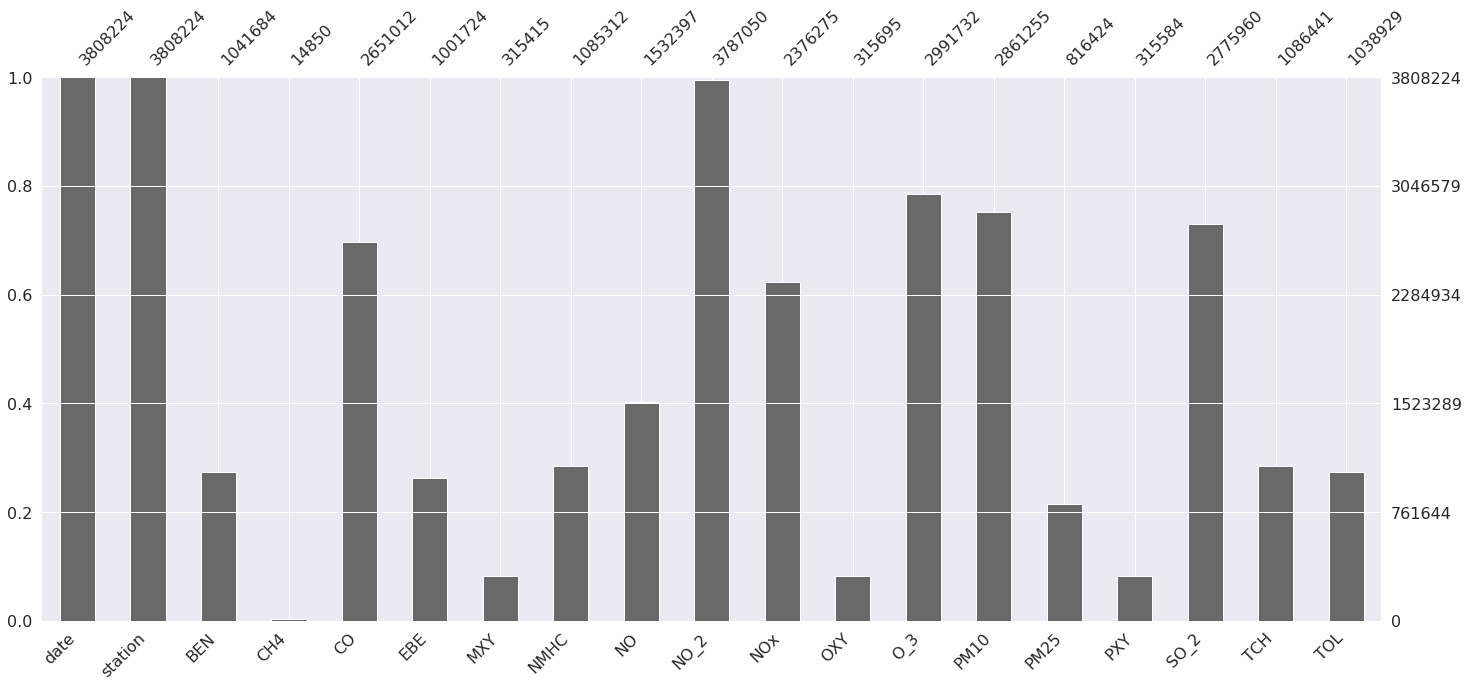

In [ ]:
msno.bar(frame);

# Where are the stations?

In [ ]:
stations = pd.read_csv('../input/stations.csv')
stations.head(1)

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635


In [ ]:
locations  = stations[['lat', 'lon']]
locationlist = locations.values.tolist()

popup = stations[['name']]

import folium
map_osm = folium.Map(location=[40.44, -3.69],
                    # tiles='Stamen Toner',
                     zoom_start=11) 

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=popup.iloc[point,0]).add_to(map_osm)
    
map_osm

# Lets focus on Ozone 
* **`O_3`** ozone level measured in **μg/m³**. 
* High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.

## Tropospheric “bad” ozone [Source](https://ozonewatch.gsfc.nasa.gov/facts/SH.html)
Although ozone high up in the stratosphere provides a shield to protect life on Earth, direct contact with ozone is harmful to both plants and animals (including humans). Ground-level, “bad,” ozone forms when **nitrogen oxide** gases from vehicle and industrial emissions react with volatile organic compounds (carbon-containing chemicals that evaporate easily into the air, such as paint thinners). In the troposphere near the Earth’s surface, the natural concentration of ozone is about 10 parts per billion (0.000001 percent). According to the Environmental Protection Agency, exposure to ozone levels of greater than **70 parts per billion for 8 hours or longer is unhealthy**. Such concentrations occur in or near cities during periods where the atmosphere is warm and stable. The harmful effects can include throat and lung irritation or aggravation of asthma or emphysema.

## Concentration
[Source](https://cfpub.epa.gov/ncer_abstracts/index.cfm/fuseaction/display.files/fileID/14285)

concentration (ppb) = 24.45 x concentration (ug/m3) ÷ molecular weight 

for $O_3 = 48 g/mol$


## Eight-Hour Average Ozone Concentrations

[Source](https://www3.epa.gov/region1/airquality/avg8hr.html)

Based on extensive scientific evidence about the effects of ozone on public health and welfare, on October 1, 2015, EPA strengthened the ground-level ozone standard to 0.070 ppm, averaged over an 8-hour period. This standard is met at an air quality monitor when the 3-year average of the annual fourth-highest daily maximum **8-hour average ozone concentration** is less than or equal to 0.070 ppm.

In [ ]:
cols = ['date', 'station', 'O_3']
o3 = frame[cols]

o3['date'] = pd.to_datetime(o3['date'])
o3['ppb'] = 24.45*o3['O_3'] /48

o3.head()

,date,station,O_3,ppb
108960,2001-01-02 01:00:00,28079001,NaN,NaN
108986,2001-01-02 02:00:00,28079001,NaN,NaN
109012,2001-01-02 03:00:00,28079001,NaN,NaN
109038,2001-01-02 04:00:00,28079001,NaN,NaN
109064,2001-01-02 05:00:00,28079001,NaN,NaN


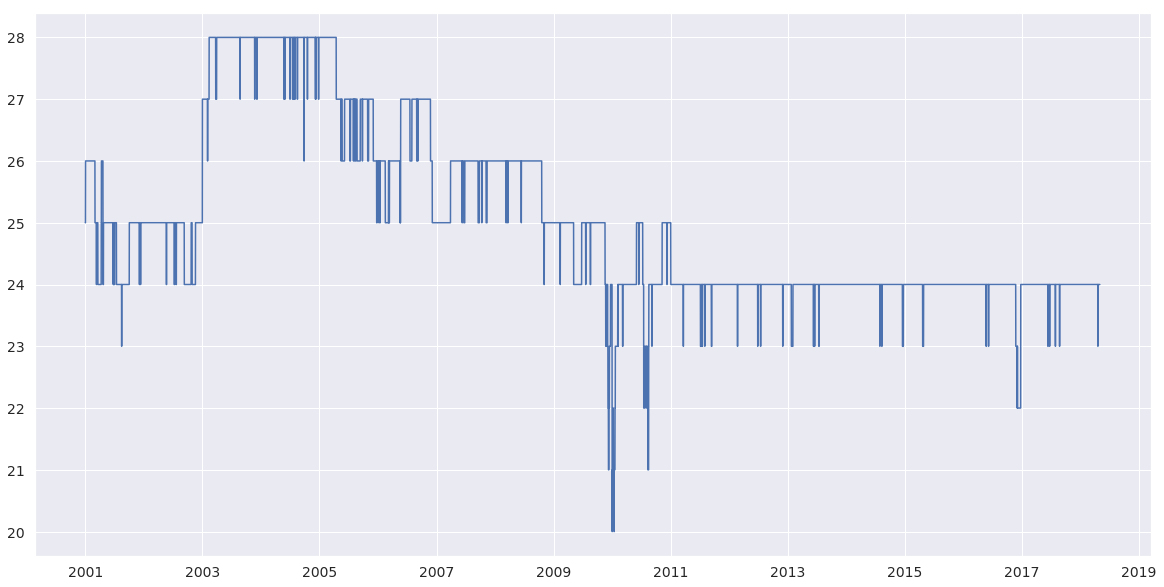

In [ ]:
# active stations with time
plt.plot(o3.groupby(['date']).station.nunique());

In [ ]:
# non-nulls per station
count_rows = pd.DataFrame(o3.groupby(['station']).O_3.count())
top3 = count_rows.sort_values('O_3', ascending=False).head(3)
top3

,O_3
station,
28079016,151131
28079024,149135
28079018,149067


In [ ]:
stations[stations.id == top3.index[0]]

,id,name,address,lon,lat,elevation
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693


In [ ]:
# select station with most data
o3_station = o3[o3.station == top3.index[0]]

# Calculate Eight-Hour Average Ozone Concentrations
o3_station['ppb_rolling'] = o3_station['ppb'].rolling(8).mean()

del o3_station['station']
del o3_station['O_3']
del o3_station['ppb']

o3_station = o3_station.sort_values("date")

o3_station.columns = ['ds', 'y']
o3_station.set_index('ds', inplace=True)

# Resample to daily max
o3_station = o3_station.resample('D', how='max')

# Any missing dates?
d = pd.DataFrame(pd.date_range(start= o3_station.index.min(), end= o3_station.index.max(), freq='D'))   

o3_station.reset_index(level=0, inplace=True)
o3_station = d.join(o3_station)
del o3_station['ds']

In [ ]:
o3_station.columns = ['ds', 'y']

# fill na 
o3_station['y'].fillna(0, inplace=True)

In [ ]:
# 3 years in hours
i = 3*365 

# Train test split 
train = o3_station[1:-i]
test = o3_station[-i:]

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5234 entries, 1 to 5234
Data columns (total 2 columns):
ds    5234 non-null datetime64[ns]
y     5234 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 81.9 KB


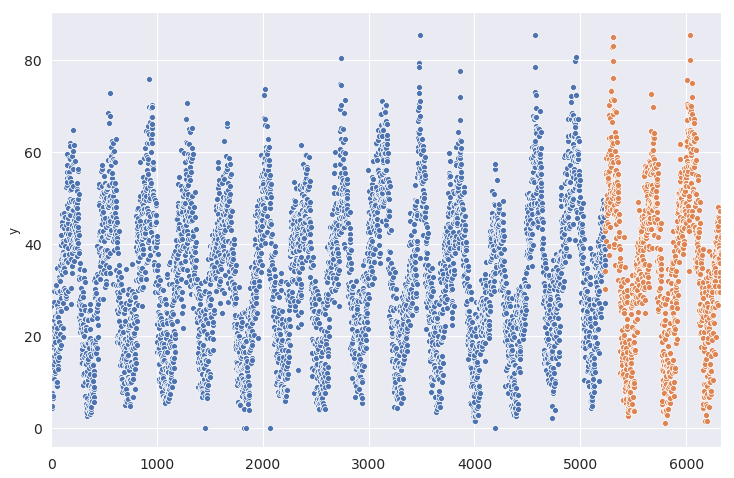

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(x=train.index, y=train.y)
ax = sns.scatterplot(x=test.index, y=test.y)

ax.axes.set_xlim(train.index.min(), test.index.max());

In [ ]:
train.reset_index(level=0, inplace=True)
test.reset_index(level=0, inplace=True)

train['y'] = np.log1p(train.y)
test['y'] = np.log1p(test.y)

train.head()

,index,ds,y
0,1,2001-01-02,3.311157
1,2,2001-01-03,2.948388
2,3,2001-01-04,2.916853
3,4,2001-01-05,2.146998
4,5,2001-01-06,3.099670


# Modelling with fbprophet

In [ ]:
%%time

m = Prophet(changepoint_prior_scale=0.01) 
m.fit(train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1.37 s, sys: 20 ms, total: 1.39 s
Wall time: 1.37 s


In [ ]:
%%time
future = m.make_future_dataframe(periods=i, freq='D')

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

CPU times: user 24.3 s, sys: 17.3 s, total: 41.7 s
Wall time: 18.5 s


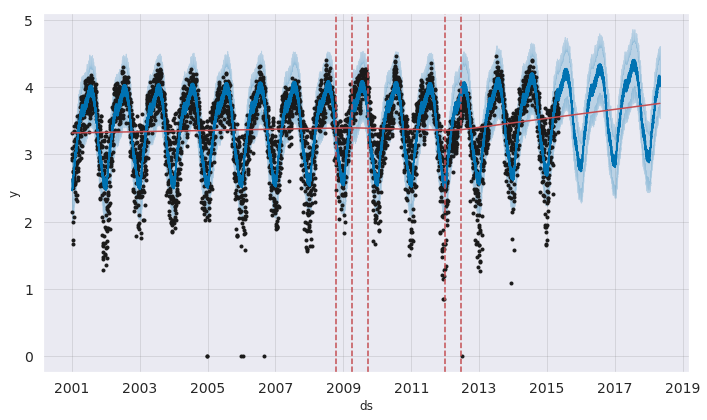

In [ ]:
from  fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

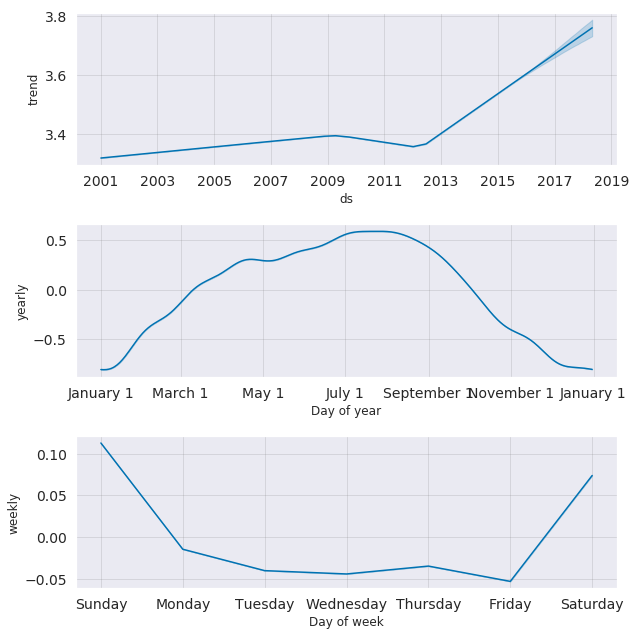

In [ ]:
fig2 = m.plot_components(forecast);

In [ ]:
test = pd.concat([test.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

cols = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test = test[cols]
#test['y'] = np.expm1(test.y)
#test['yhat'] = np.expm1(test.yhat)
#test['yhat_lower'] = np.expm1(test.yhat_lower)
#test['yhat_upper'] = np.expm1(test.yhat_upper)

test.tail()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-04-27,3.667131,4.007694,3.578156,4.465005
2018-04-28,3.758781,4.133091,3.685060,4.590329
2018-04-29,3.749835,4.170310,3.745559,4.613437
2018-04-30,3.655678,4.041044,3.604180,4.503967
2018-05-01,3.491524,4.013725,3.541482,4.442203


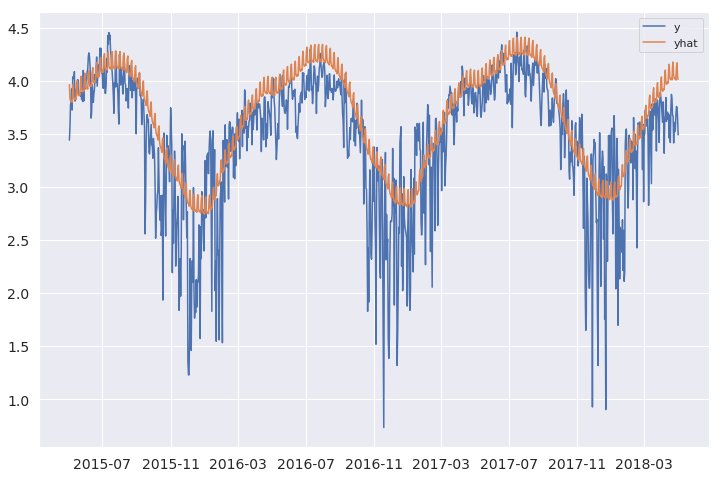

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.plot(test.y)
plt.plot(test.yhat)
plt.legend();

In [ ]:
test['e'] = test.y - test.yhat

rmse = np.round(np.sqrt(np.mean(test.e**2)),2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 2)
print('RMSE =', rmse)
print('MAPE =', mape, '%')

RMSE = 0.43
MAPE = 11.43 %


# Modelling with ARIMA

In [ ]:
cols = ['ds', 'y']
train = train[cols]

train.set_index('ds', inplace=True)
train.head()

,y
ds,
2001-01-02,3.311157
2001-01-03,2.948388
2001-01-04,2.916853
2001-01-05,2.146998
2001-01-06,3.099670


In [ ]:
test.head()

,y,yhat,yhat_lower,yhat_upper,e
ds,,,,,
2015-05-03,3.441832,3.964182,3.520721,4.399545,-0.522350
2015-05-04,3.557188,3.835912,3.394818,4.244147,-0.278724
2015-05-05,3.776436,3.809905,3.379789,4.249485,-0.033469
2015-05-06,3.799501,3.806121,3.419743,4.249468,-0.006620
2015-05-07,3.923959,3.816353,3.391503,4.259930,0.107606


In [ ]:
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

## Stationarity check and Seasonal decomposition

Dickey–Fuller test: p=0.000069


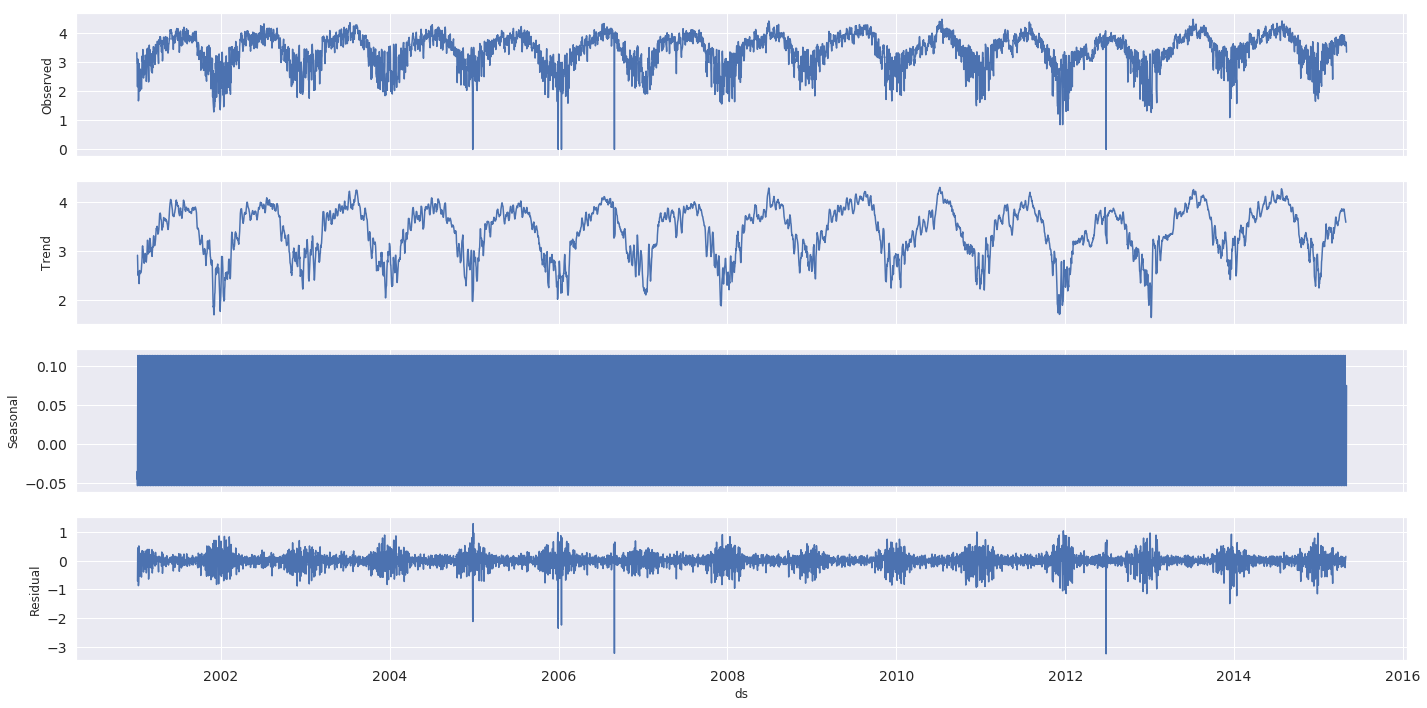

In [ ]:
seasonal_decompose(train.y, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(train.y)[1])

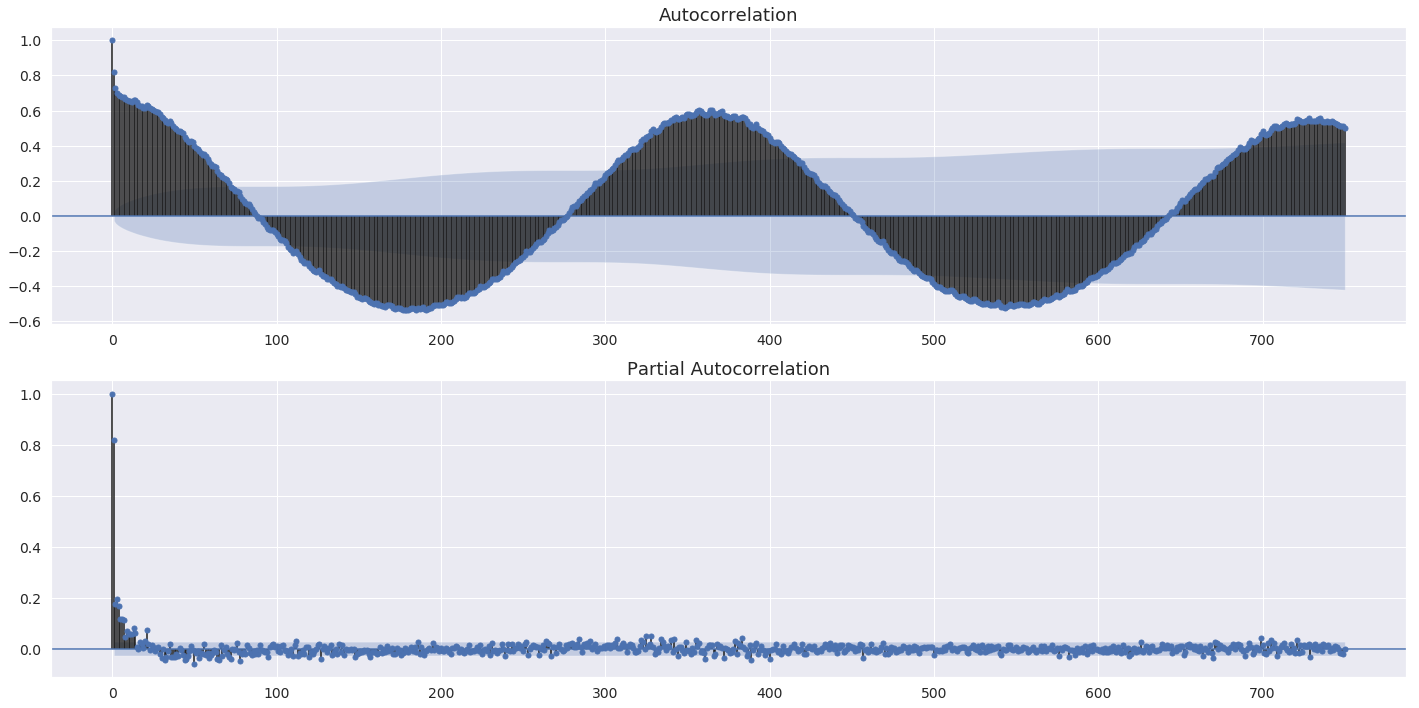

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(train.y[0:].values.squeeze(), lags=750, ax=ax)
ax = plt.subplot(212)
plot_pacf(train.y[0:].values.squeeze(), lags=750, ax=ax)
plt.tight_layout()

In [ ]:
# Initial approximation of parameters
ps = range(0, 2)
d = 1
qs = range(0, 2)

parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [ ]:
%%time 

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0)
CPU times: user 5.98 s, sys: 1.4 s, total: 7.39 s
Wall time: 5.64 s


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

  parameters          aic
2     (1, 1)  2639.984389
0     (0, 1)  3170.778461
1     (1, 0)  3608.546465


In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 5234
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1316.992
Date:                Fri, 25 Oct 2019   AIC                           2639.984
Time:                        21:09:35   BIC                           2659.673
Sample:                    01-02-2001   HQIC                          2646.869
                         - 05-02-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4063      0.010     41.686      0.000       0.387       0.425
ma.L1         -0.8941      0.007   -135.163      0.000      -0.907      -0.881
sigma2         0.0968      0.001    136.635      0.0

In [ ]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


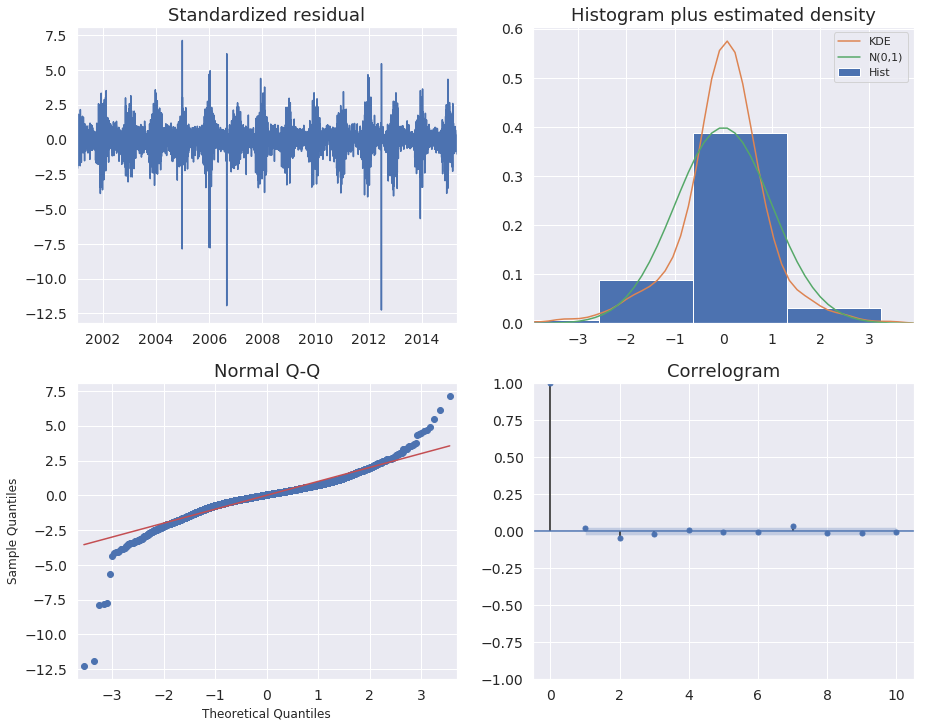

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
test['yhat_ARIMA'] = best_model.forecast(test.shape[0])
test.tail()

,y,yhat,yhat_lower,yhat_upper,e,yhat_ARIMA
ds,,,,,,
2018-04-27,3.667131,4.007694,3.578156,4.465005,-0.340563,3.641612
2018-04-28,3.758781,4.133091,3.685060,4.590329,-0.374310,3.641612
2018-04-29,3.749835,4.170310,3.745559,4.613437,-0.420475,3.641612
2018-04-30,3.655678,4.041044,3.604180,4.503967,-0.385366,3.641612
2018-05-01,3.491524,4.013725,3.541482,4.442203,-0.522201,3.641612


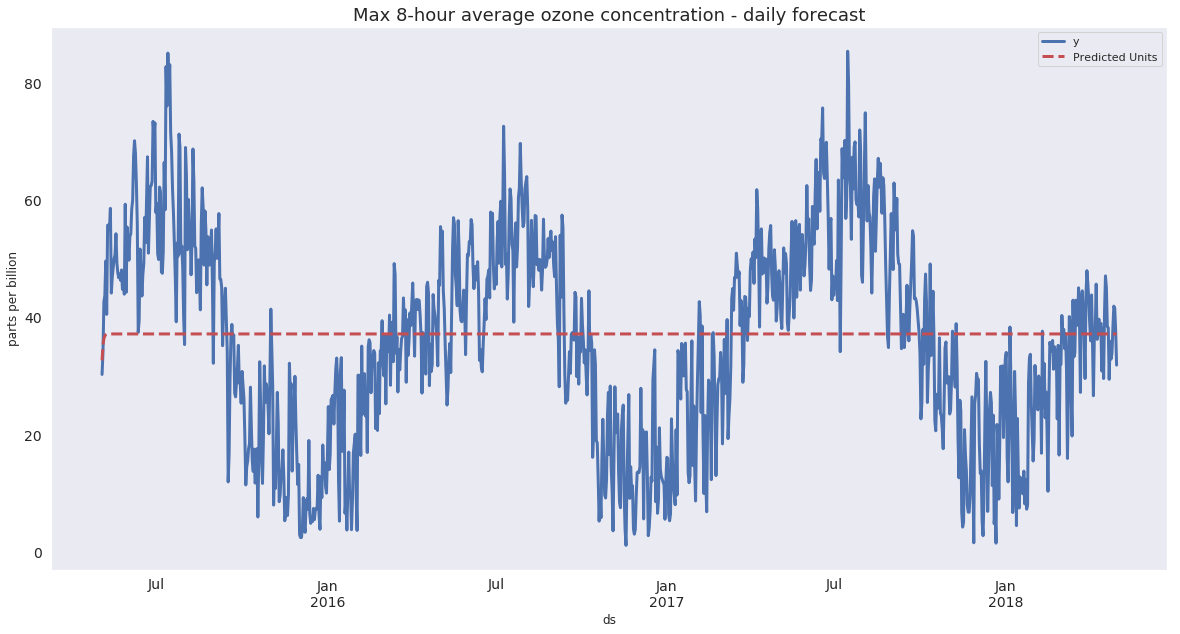

In [ ]:
np.expm1(test.y).plot(linewidth=3)
np.expm1(test.yhat_ARIMA).plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Max 8-hour average ozone concentration - daily forecast')
plt.ylabel('parts per billion');

In [ ]:
test['e'] = test.y - test.yhat_ARIMA

rmse = np.round(np.sqrt(np.mean(test.e**2)),2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 2)
print('RMSE =', rmse)
print('MAPE =', mape, '%')

RMSE = 0.66
MAPE = 17.96 %


# Results so far

In [ ]:
test.tail()

,y,yhat,yhat_lower,yhat_upper,e,yhat_ARIMA
ds,,,,,,
2018-04-27,3.667131,4.007694,3.578156,4.465005,0.025519,3.641612
2018-04-28,3.758781,4.133091,3.685060,4.590329,0.117169,3.641612
2018-04-29,3.749835,4.170310,3.745559,4.613437,0.108223,3.641612
2018-04-30,3.655678,4.041044,3.604180,4.503967,0.014066,3.641612
2018-05-01,3.491524,4.013725,3.541482,4.442203,-0.150088,3.641612


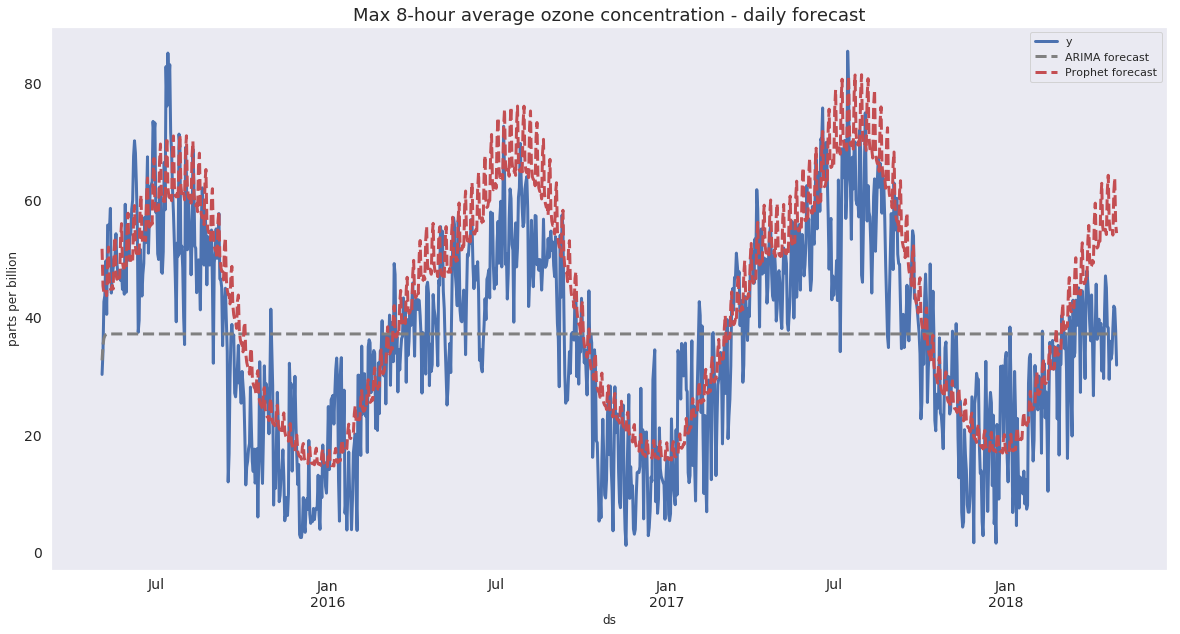

In [ ]:
np.expm1(test.y).plot(linewidth=3)

np.expm1(test.yhat_ARIMA).plot(color='grey', ls='--', label='ARIMA forecast', linewidth=3)
np.expm1(test.yhat).plot(color='r', ls='--', label='Prophet forecast', linewidth=3)

plt.legend()
plt.grid()
plt.title('Max 8-hour average ozone concentration - daily forecast')
plt.ylabel('parts per billion');